# Eggholder Function
The Eggholder Function is a 2-dimensional function with many local minima, making it a challenging optimization problem.
It's mathematical formulation is given as $$-(x_2+47)\sin(\sqrt{\left|x_2+\frac{x_1}{2}+47\right|})-x_1\sin(\sqrt{|x_1-(x_2+47)|}) $$

## Input Domain

The Eggholder Function is typically evaluated over the region $x_i\in[-512,512], \forall i=1,2.$

## Global Minimum

It's minimum value is $f(\textbf{x}^*)=-959.6407$, located at $\textbf{x}^*=(512,404.2319).$

## Function Visualization

In [2]:
import numpy as np
import matplotlib.pyplot as plt


In [3]:
# Objective function
def egg_holder(x1,x2):
    return -(x2 + 47)*np.sin((np.abs(x2 + x1/2 + 47))**0.5) - x1*np.sin((np.abs(x1 - (x2 + 47)))**0.5)

print(egg_holder(512,404.2319))

-959.6406627106155


Text(0.5, 0.92, 'Eggholder Surface Plot')

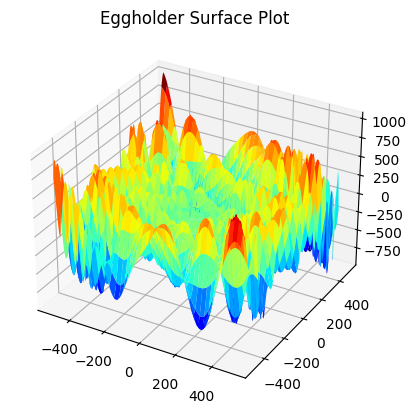

In [5]:
# Plot Drop-Wave in 3D
r_min, r_max = -512, 512
x_axis = y_axis = np.arange(r_min, r_max, 5)
x1, x2 = np.meshgrid(x_axis, y_axis)
f = egg_holder(x1, x2)

figure = plt.figure()
axis = figure.add_subplot(111, projection="3d")
axis.plot_surface(x1, x2, f, cmap="jet", shade="false")

# Set the title
axis.set_title("Eggholder Surface Plot")

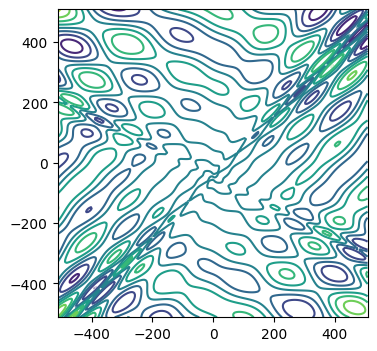

In [6]:
# Contour Plot
figure = plt.figure(figsize=(4,4))
plt.contour(x1,x2,f)

## DeepLifting Solution

In [7]:
# imports
import time
import sys
import math

# Adding PyGRANSO directories. Should be modified by user
sys.path.append("/home/seanschweiger/dl_testing/Deeplifting")

import torch
from pygranso.private.getNvar import getNvarTorch
from pygranso.pygranso import pygranso
from pygranso.pygransoStruct import pygransoStruct

from deeplifting.models import DeepliftingMLP

In [10]:
# Set device as GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def eggholder(x1,x2):
    return -(x2 + 47)*torch.sin((torch.abs(x2 + x1/2 + 47))**0.5) - x1*torch.sin((torch.abs(x1 - (x2 + 47)))**0.5)
    
def user_fn(model,inputs):
    output = model(inputs=None)
    x1, x2 = output

    # Can map x1 and x2 to [0,1] 
    # and shift interval to accomplish
    # same thing as constraints
    x1 = torch.sigmoid(x1) * (-512 - 512) + 512
    x2 = torch.sigmoid(x2) * (-512 - 512) + 512

    # Objective fn.
    f = eggholder(x1, x2)

    # Inequality constraint
    ci = None

    # Equality constraint
    ce = None

    return [f, ci, ce]

In [20]:
# Build model
model = DeepliftingMLP(input_size=50, layer_sizes=(128,256,256,128), output_size=2)
model = model.to(device=device, dtype=torch.double)
nvar = getNvarTorch(model.parameters())
print(nvar)

139498


In [21]:
torch.manual_seed(1)

opts = pygransoStruct()

x0 = (
    torch.nn.utils.parameters_to_vector(model.parameters())
    .detach()
    .reshape(nvar, 1)
    .to(device=device, dtype=torch.double)
)

opts.x0 = x0
opts.torch_device = device
opts.print_frequency = 10
opts.limited_mem_size = 100
opts.stat_l2_model = False
opts.double_precision = True
opts.viol_ineq_tol = 1e-8
opts.opt_tol = 1e-8

points = []
comb_fn = lambda model: user_fn(model, points)

# Run the main algorithm
start = time.time()
soln = pygranso(var_spec=model, combined_fn=comb_fn, user_opts=opts)
end = time.time()

print(f"Starting point for this problem = {x0}\n")
print(f"Total Wall Time: {end-start}\n")
print(soln.final.f)



╔═════ QP SOLVER NOTICE ════════════════════════════════════════════════════════════════════════╗
║  PyGRANSO requires a quadratic program (QP) solver that has a quadprog-compatible interface,  ║
║  the default is osqp. Users may provide their own wrapper for the QP solver.                  ║
║  To disable this notice, set opts.quadprog_info_msg = False                                   ║
╚═══════════════════════════════════════════════════════════════════════════════════════════════╝
══════════════════════════════════════════════════════════════════════════════════════════════╗
PyGRANSO: A PyTorch-enabled port of GRANSO with auto-differentiation                          ║ 
Version 1.2.0                                                                                 ║ 
Licensed under the AGPLv3, Copyright (C) 2021-2022 Tim Mitchell and Buyun Liang               ║ 
══════════════════════════════════════════════════════════════════════════════════════════════╣
Problem specifications:  

## PyGRANSO Solution

### Function Setup

In [22]:
# Set device as GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Input variables
var_in = {'x1': [1], 'x2':[1]}

def comb_fn(X_struct):
    x1 = X_struct.x1
    x2 = X_struct.x2

    # objective function
    f = -(x2 + 47)*torch.sin((torch.abs(x2 + x1/2 + 47))**0.5) - x1*torch.sin((torch.abs(x1 - (x2 + 47)))**0.5)

    # inequality constraint
    ci = pygransoStruct()
    ci.c1 = -x1 - 512
    ci.c2 = x1 - 512
    ci.c3 = -x2 - 512
    ci.c4 = x2 - 512


    # equality constraint
    ce = None

    return [f,ci,ce]

### Main Algorithm

In [23]:
# run 10 trials with different random starting points
for i in range(10):
    np.random.seed(i)
    opts = pygransoStruct()
    # initialize starting vector with random values in [-10,10]
    opts.x0 = torch.rand(size=(2,1), device=device, dtype=torch.double) * 20 - 10 
    opts.torch_device = device
    start = time.time()
    soln = pygranso(var_spec = var_in,combined_fn = comb_fn, user_opts = opts)
    end = time.time()
    print("Total Wall Time: {}s".format(end - start))
    print(soln.final.x, soln.final.f)



╔═════ QP SOLVER NOTICE ════════════════════════════════════════════════════════════════════════╗
║  PyGRANSO requires a quadratic program (QP) solver that has a quadprog-compatible interface,  ║
║  the default is osqp. Users may provide their own wrapper for the QP solver.                  ║
║  To disable this notice, set opts.quadprog_info_msg = False                                   ║
╚═══════════════════════════════════════════════════════════════════════════════════════════════╝
═════════════════════════════════════════════════════════════════════════════════════════════════════════════════╗
PyGRANSO: A PyTorch-enabled port of GRANSO with auto-differentiation                                             ║ 
Version 1.2.0                                                                                                    ║ 
Licensed under the AGPLv3, Copyright (C) 2021-2022 Tim Mitchell and Buyun Liang                                  ║ 
═════════════════════════════════════════════

## IPOPT Solution

In [24]:
# import statements
import numpy as np
from cyipopt import minimize_ipopt

# Objective function
def objective(x):
    return -(x[1] + 47)*np.sin((np.abs(x[1] + x[0]/2 + 47))**0.5) - x[0]*np.sin((np.abs(x[0] - (x[1] + 47)))**0.5)

for i in range(10):
    np.random.seed(i)
    # initialize starting vector with random values in [-512,512]
    x0 = np.random.rand(2) * 1024 - 512

    result = minimize_ipopt(objective, x0)
    print(f"Trial {i+1}")
    print("Optimal x* found: ", result.x)
    print("Minimum value found: ", objective(result.x))


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Trial 1
Optimal x* found:  [ 13.22583744 151.32842173]
Minimum value found:  -206.5719395393715
Trial 2
Optimal x* found:  [-76.1459198  191.15514835]
Minimum value found:  -306.72046784321947
Trial 3
Optimal x* found:  [-1560.92240403 -9065.44507563]
Minimum value found:  -10574.448504026243
Trial 4
Optimal x* found:  [ 13.22582527 151.32842177]
Minimum value found:  -206.57193953939475
Trial 5
Optimal x* found:  [566.80610752 101.76717673]
Minimum value found:  -705.4078552285462
Trial 6
Optimal x* found:  [-242.97925763  274.38032678]
Minimum value found:  -559.7868565506285
Trial 7
Optimal x* found:  [

## Simulated Annealing Solution

In [25]:
import numpy as np
from scipy.optimize import dual_annealing

# Objective fn.
def eggholder(x):
    return -(x[1] + 47)*np.sin((np.abs(x[1] + x[0]/2 + 47))**0.5) - x[0]*np.sin((np.abs(x[0] - (x[1] + 47)))**0.5)

bounds = [(-512,512), (-512,512)]

# Run 10 trials
results = []
for i in range(10):
    result = dual_annealing(eggholder, bounds)
    results.append(result)

print("Simulated Annealing Results")
for i,res in enumerate(results):
    print(f"Trial {i+1}")
    print(f"x: {res.x}, f(x): {res.fun}\n")

Simulated Annealing Results
Trial 1
x: [-465.69420382  385.71672039], f(x): -894.5789003902437

Trial 2
x: [-465.69412374  385.71665592], f(x): -894.578900390024

Trial 3
x: [482.35311609 432.87879427], f(x): -956.9182316144605

Trial 4
x: [482.35339482 432.87908334], f(x): -956.9182316233253

Trial 5
x: [-465.69423702  385.71668672], f(x): -894.5789003894085

Trial 6
x: [512.         404.23180553], f(x): -959.6406627208506

Trial 7
x: [512.         404.23181357], f(x): -959.6406627207696

Trial 8
x: [482.35346098 432.87915152], f(x): -956.9182316202208

Trial 9
x: [-465.6941886   385.71669103], f(x): -894.5789003903449

Trial 10
x: [439.48101207 453.97745309], f(x): -935.3379515605111



## Differential Evolution Solution

In [26]:
import numpy as np
from scipy.optimize import differential_evolution

# Objective fn.
def eggholder(x):
    return -(x[1] + 47)*np.sin((np.abs(x[1] + x[0]/2 + 47))**0.5) - x[0]*np.sin((np.abs(x[0] - (x[1] + 47)))**0.5)

bounds = [(-512,512), (-512,512)]

# Run 10 trials
results = []
for i in range(10):
    result = differential_evolution(eggholder, bounds)
    results.append(result)

print("Differential Evolution Results")
for i,res in enumerate(results):
    print(f"Trial {i+1}")
    print(f"x: {res.x}, f(x): {res.fun}\n")

Simulated Annealing Results
Trial 1
x: [482.35329653 432.87898637], f(x): -956.9182316245884

Trial 2
x: [512.         404.23180233], f(x): -959.6406627208421

Trial 3
x: [-465.69413994  385.71668566], f(x): -894.5789003905384

Trial 4
x: [-456.88592876 -382.62349077], f(x): -786.5259940764743

Trial 5
x: [-456.88574663 -382.62331924], f(x): -786.525994078319

Trial 6
x: [-465.69414504  385.71669472], f(x): -894.5789003905903

Trial 7
x: [-465.6941748   385.71672059], f(x): -894.5789003904506

Trial 8
x: [482.35308445 432.87876402], f(x): -956.9182316126085

Trial 9
x: [482.35332952 432.87901706], f(x): -956.9182316245798

Trial 10
x: [479.04572312 434.50619301], f(x): -955.255152125092

